<h2>Prototype</h2>

In [106]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.signal import get_window
from scipy.io import wavfile
from scipy.signal import savgol_filter
from scipy.signal import wiener
from scipy.signal import butter, filtfilt
import IPython

In [144]:
fs, x = wavfile.read("samples/tu-jesty.wav")
x = x / np.max(abs(x))

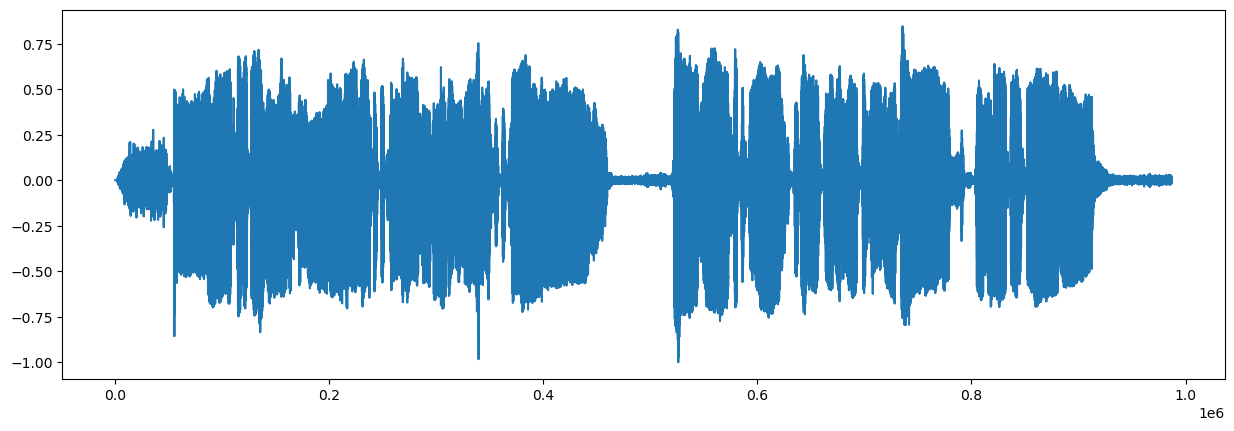

In [145]:
plt.figure().set_figwidth(15)
plt.plot(x)
IPython.display.Audio(x, rate=fs)

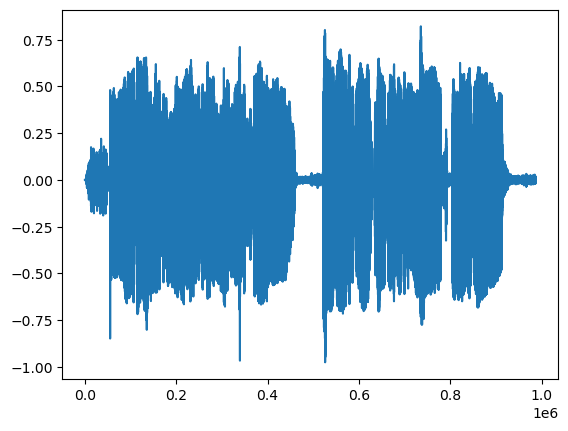

In [146]:
x = wiener(x, mysize=10)

plt.plot(x)
IPython.display.Audio(x, rate=fs)

In [147]:
M=4095
N=4096
H=256

hM1 = int(math.floor((M + 1) / 2))
hM2 = int(math.floor(M / 2))
eps = np.finfo(float).eps

In [148]:
w  = get_window('blackman', M)
w = w / sum(w)

In [149]:
def computeSpectrum(x):
    spectrum = []
    Mspec = []
    l = 0
    while l < len(x) - M:
        y = x[l: l + M]
        rmsframe = np.sqrt(np.dot(y, y) / M)
        
        if rmsframe > 0.1: 
            y = y / np.max(abs(y))
            y = y * w

            fftBuffer = np.zeros(N)
            fftBuffer[: hM1] = y[hM2:] 
            fftBuffer[N - hM2:] = y[: hM2]

            X = fft(fftBuffer)
            absX = abs(X)
            absX[absX < np.finfo(float).eps] = np.finfo(float).eps
            mX = 10 * np.log10(absX)
            spectrum.append(mX)
            Mspec.append(absX)

        l += H
    
    return spectrum, Mspec

In [150]:
spectrum, Mspec = computeSpectrum(x)

In [151]:
t = np.arange(len(spectrum)) * H / fs
fqs = np.arange(N) * fs / N
f = int(2500 * N / fs)

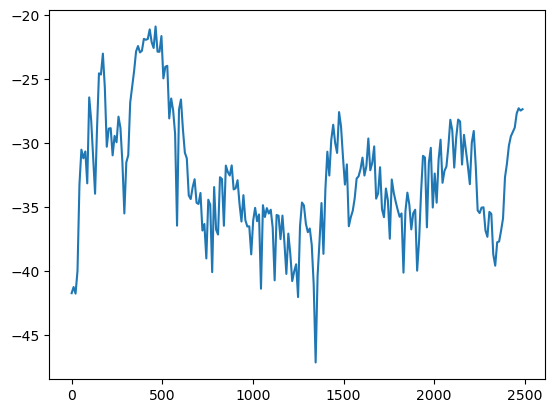

In [152]:
plt.plot(fqs[:f], spectrum[0][:f])

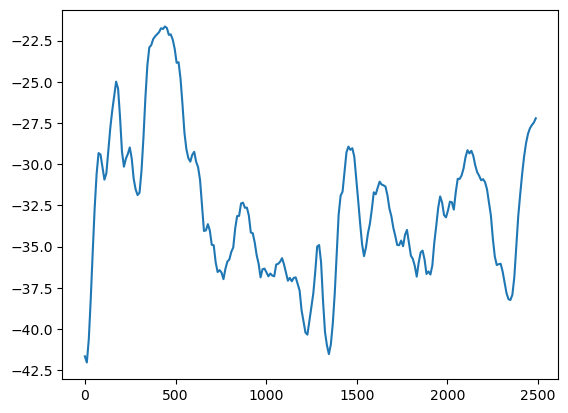

In [153]:
filtered = savgol_filter(spectrum[0][:f], 15, 5)
plt.plot(fqs[:f], filtered)

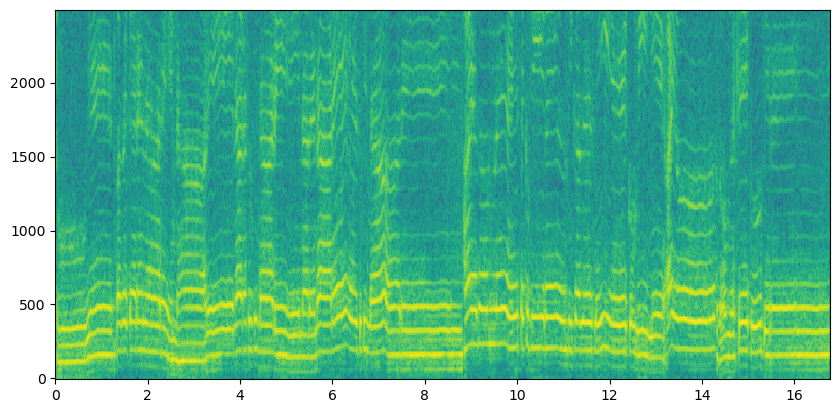

In [154]:
f = int(2500 * N / fs)
spectrum = np.array(spectrum)
plt.figure().set_figwidth(10)
fqs = np.arange(N) * fs / N
plt.pcolormesh(t, fqs[:f], spectrum.T[:f])

In [155]:
centroid = []

for spec in Mspec:
    ck = 0
    for i in range(1, len(spec[:int(N/2)])):
        ck += i * spec[i]
    centroid.append(ck / sum(spec[1:int(N/2)]))

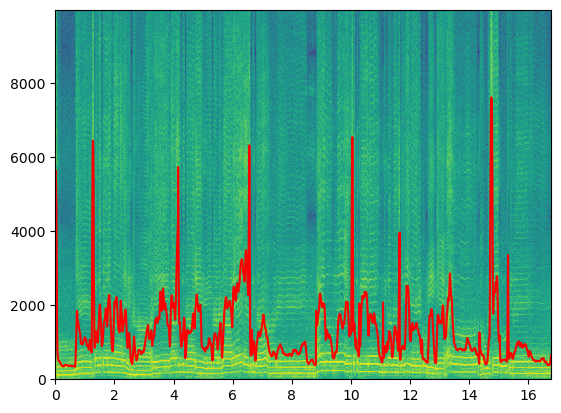

In [156]:
plt.pcolormesh(t, fqs[:int(10000 * N / fs)], spectrum.T[:int(10000 * N / fs)])
plt.plot(t, [i * fs / N for i in centroid], c='r')

In [157]:
peakFrqs = []
peakMags = []

for i in range(len(spectrum)):
    mX = savgol_filter(spectrum[i][:f], 15, 5)
    peaks = []
    mags = []
    k = 1

    while k < len(mX) - 1:
        if len(peaks) == 8:
                break
        if mX[k] < -25: 
            k += 1
            continue

        if mX[k-1] < mX[k] and mX[k] > mX[k+1]:
            tmp = np.zeros(len(mX)) - 100
            tmp[k:k+15] = mX[k:k+15]
            peaks.append(np.argmax(tmp) * fs / N)
            mags.append(mX[np.argmax(tmp)])
            k = np.argmax(tmp) + 5
        else: k += 1

    peakFrqs.append(peaks)
    peakMags.append(mags)

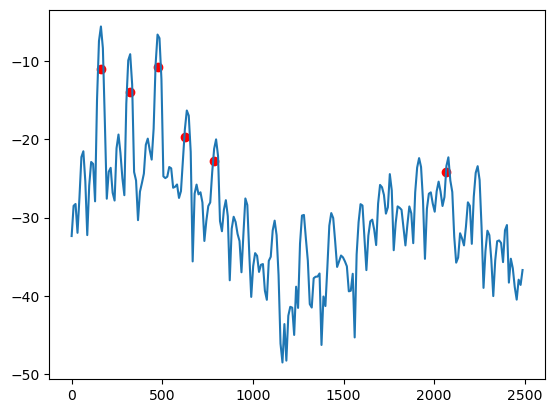

In [158]:
plt.plot(fqs[:f], spectrum[200][:f])
plt.scatter(peakFrqs[200], peakMags[200], c='r')

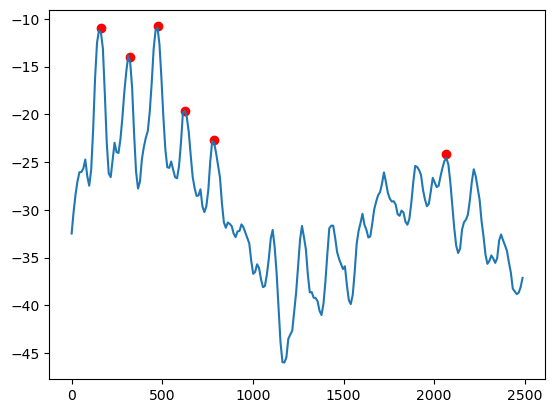

In [159]:
plt.plot(fqs[:f], savgol_filter(spectrum[200][:f], 10, 2))
plt.scatter(peakFrqs[200], peakMags[200], c='r')

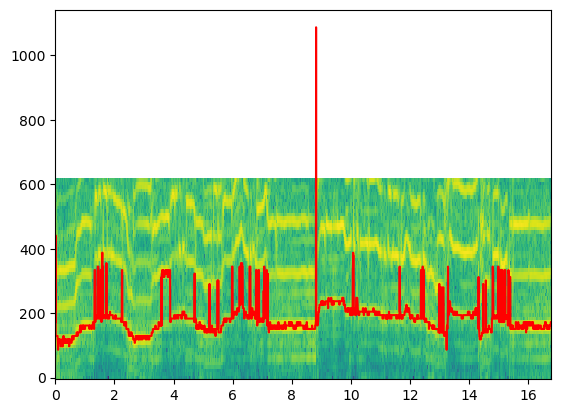

In [160]:
plt.pcolormesh(t, fqs[:f//4], spectrum.T[:f//4])
plt.plot(t, [i[0] for i in peakFrqs], c='r')

In [161]:
fundamentals = []
for i in range(len(peakFrqs)):
    candidates = []
    
    for j in range(len(peakFrqs[i]) - 1):
        #print(peaks_k[i][j+1] - peaks_k[i][j])
        temp = peakFrqs[i][j+1] - peakFrqs[i][j]
        if temp > 100 and temp < 255:
            candidates.append(peakFrqs[i][j+1] - peakFrqs[i][j])
        
    if len(candidates) == 0: f0 = 100
    else: 
        f0 = candidates[0]
        least_err = 99999

        for c in candidates:
            #print("Candidate: {}".format(c))
            if c < 80: continue
            errpm = 0
            errmp = 0

            k = 1
            overtone = c
            predicted = []

            while overtone < peakFrqs[i][-1] + c:
                predicted.append(overtone)
                overtone += c

            for j in range(len(peakFrqs[i])):
                closestHarm = predicted[np.abs(predicted - peakFrqs[i][j]).argmin()]
                #print("measured: {}".format(peakFrqs[i][j]), end='')
                #print(", predicted: {}".format(closestHarm))

                errpm += (closestHarm - peakFrqs[i][j]) * (closestHarm)**(-0.5) + peakMags[i][j] / (max(peakMags[i]) - 0.01) * (1.4 * (closestHarm - peakFrqs[i][j]) * (closestHarm)**(-0.5) - 0.5)
                errmp += (closestHarm - peakFrqs[i][j]) * (peakFrqs[i][j])**(-0.5) + peakMags[i][j] / (max(peakMags[i]) - 0.01) * (1.4 * (closestHarm - peakMags[i][j]) * (peakFrqs[i][j])**(-0.5) - 0.5)

            err_tot = (errpm + errmp) / len(peakFrqs[i])
            if err_tot < least_err:
                least_err = err_tot
                f0 = c
    
    fundamentals.append(f0)
len(fundamentals)

2891

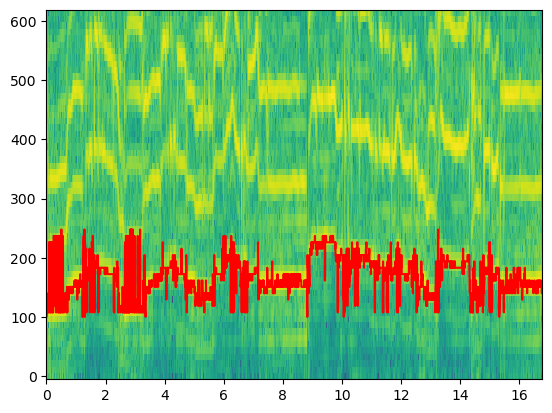

In [162]:
plt.pcolormesh(t, fqs[:f//4], spectrum.T[:f//4])
plt.plot(t, fundamentals, c='r')

<h4>Needs a nueral network to identify the peaks</h4>

In [163]:
notes = np.round([69 + 12 * np.log2((f0 + 0.0001) / 440) for f0 in fundamentals]).tolist()
notestoFreqs = [440 * (2 ** ((i - 69) / 12)) for i in notes] 

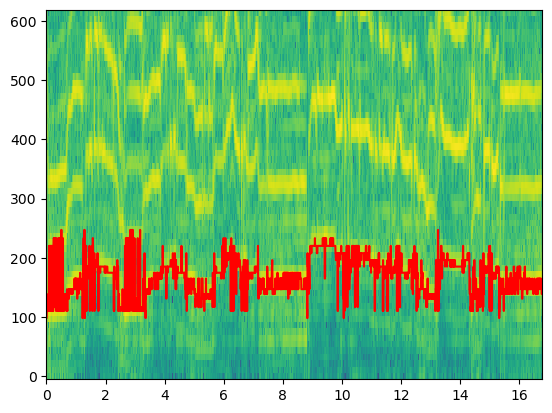

In [164]:
plt.pcolormesh(t, fqs[:f//4], spectrum.T[:f//4])
plt.plot(t, notestoFreqs, c='r')

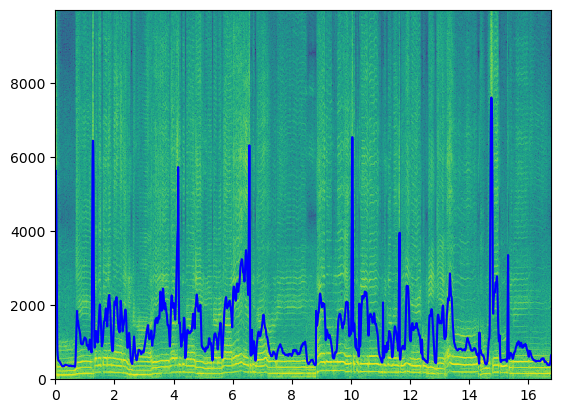

In [165]:
plt.pcolormesh(t, fqs[:int(10000 * N / fs)], spectrum.T[:int(10000 * N / fs)])
plt.plot(t, [i * fs / N for i in centroid], c='b')

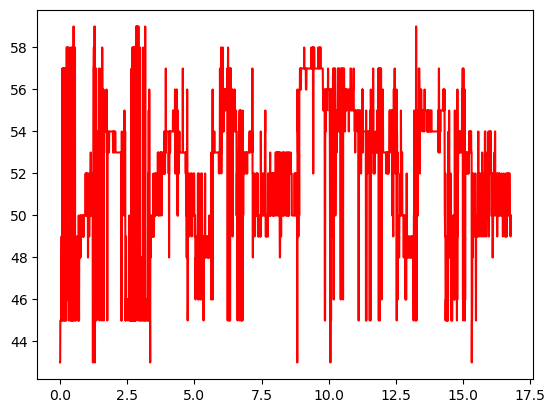

In [166]:
plt.plot(t, notes, c='r')

In [167]:
import json

In [168]:
tujesty = []
talasaki = []

with open('tu-jesty.json', 'r') as fp:
    tujesty = json.load(fp)['melody']
    
with open('talasaki.json', 'r') as fp:
    talasaki = json.load(fp)['melody']
    
tujesty = (np.array(tujesty) - np.mean(tujesty)).tolist()
talasaki = (np.array(talasaki) - np.mean(talasaki)).tolist()
notes = (np.array(notes) - np.mean(notes)).tolist()

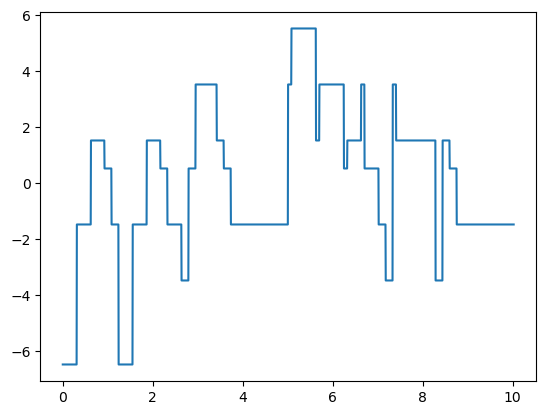

In [169]:
mt1 = np.arange(len(tujesty)) * H / fs
plt.plot(mt1, tujesty)

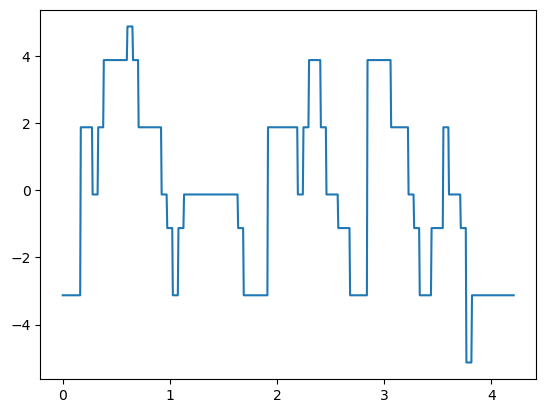

In [170]:
mt2 = np.arange(len(talasaki)) * H / fs
plt.plot(mt2, talasaki)

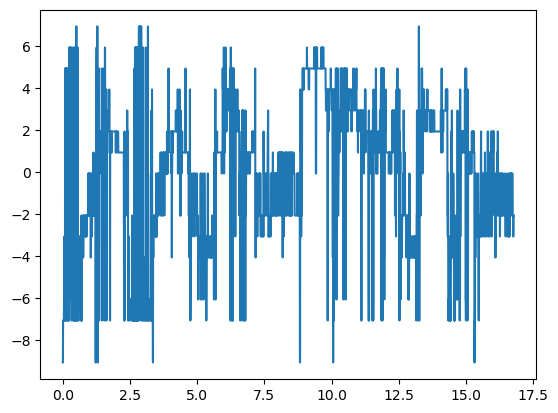

In [171]:
plt.plot(t, notes)

In [172]:
from fastdtw import fastdtw

In [173]:
distancetujesty, path = fastdtw(notes, tujesty)
distancetalasaki, path = fastdtw(notes, talasaki)

print(f"Distance tujesty: {distancetujesty}")
print(f"Distance talasaki: {distancetalasaki}")

Distance tujesty: 4622.6610449735235
Distance talasaki: 5524.9722049907


In [174]:
if distancetujesty < distancetalasaki:
    print('The song is tu-jesty')
else:
    print('The song is talasaki')

The song is tu-jesty
